In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import os
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
img_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"

### Processing the Image

In [4]:
def process_augment_data(img_dir, augment_size=5):
    x_data = []

    for filename in os.listdir(img_dir):
        if filename.endswith(".png"):
            img_path = os.path.join(img_dir, filename)
            img = load_img(img_path, target_size=(60, 60), color_mode="grayscale")
            img_array = img_to_array(img) / 255.0  # Normalize the image

            x_data.append(img_array)

    x_data = np.array(x_data)  # Convert list to NumPy array

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    
    for img in x_data:
        img = img.reshape((1,) + img.shape)  # Reshape for flow()
        i = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])  # Store augmented images
            i += 1
            if i >= augment_size:  # Generate `augment_size` augmented images per input
                break

    return np.array(augmented_images)  # Return all augmented images

In [5]:
img_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"

In [6]:
img_data = process_augment_data(img_dir)

In [7]:
print("Augmented data shape:", img_data.shape)

Augmented data shape: (18080, 60, 60, 1)


In [8]:
print(len(img_data))


18080


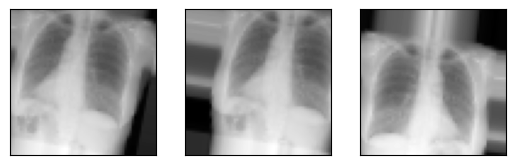

In [9]:
# plt.figure(figsize=(15,10))

for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(img_data[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # plt.title('Source')

    # ax = plt.subplot(2, 3, i+4)
    # plt.imshow(target[i])
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    # plt.title('Target')
plt.show()


### Train Test Split

In [10]:
x_train,x_test = train_test_split(img_data,test_size=0.33,random_state=42)

### Creating Auto Encoder

In [11]:
input_shape = x_train[0].shape
input_shape

(60, 60, 1)

In [12]:
# Encoder
input_layer = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)  # Flatten before passing to decoder
encoded = Reshape((8, 8, 8))(x)  # Reshape to a reasonable feature map

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder Model
autoencoder = keras.models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [14]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 2


In [15]:
autoencoder.fit(x_train, x_train, epochs=10, batch_size=32, validation_data=(x_test, x_test))


Epoch 1/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6087 - val_loss: 0.5563
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5538 - val_loss: 0.5535
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5516 - val_loss: 0.5518
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5508 - val_loss: 0.5516
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5495 - val_loss: 0.5507
Epoch 6/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5489 - val_loss: 0.5503
Epoch 7/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5501 - val_loss: 0.5502
Epoch 8/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5495 - val_loss: 0.5503
Epoch 9/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5484 - val_loss: 0.5497
Epoch 10/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5490 - val_loss: 0.5500


In [16]:
reconstructed_images = autoencoder.predict(x_test)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


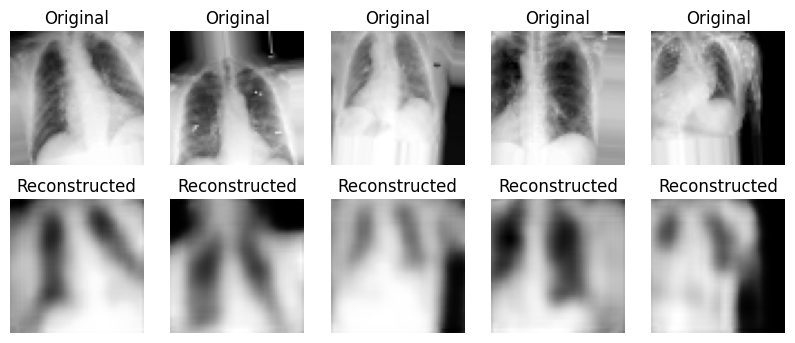

In [18]:
import matplotlib.pyplot as plt

n = 5  # Number of images to display
plt.figure(figsize=(10, 4))

for i in range(n):
    # Original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')  # Use x_test instead of x_data
    plt.title('Original')
    plt.axis('off')

    # Reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()


In [19]:
import numpy as np

# Calculate MSE for each image in the test set
reconstruction_errors = np.mean(np.square(x_test - reconstructed_images), axis=(1,2,3))


In [20]:
# Assuming you have reconstruction errors from the training set as well:
train_reconstruction_errors = np.mean(np.square(x_train - autoencoder.predict(x_train)), axis=(1,2,3))

threshold = np.mean(train_reconstruction_errors) + 2 * np.std(train_reconstruction_errors)
print("Threshold for anomaly detection:", threshold)


379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Threshold for anomaly detection: 0.0050986341666430235


In [21]:
anomalies = reconstruction_errors > threshold

for i, error in enumerate(reconstruction_errors):
    if anomalies[i]:
        print(f"Image {i} - Reconstruction error: {error:.4f} -> Anomalous (Potential Disease)")
    else:
        print(f"Image {i} - Reconstruction error: {error:.4f} -> Normal")


Image 0 - Reconstruction error: 0.0022 -> Normal
Image 1 - Reconstruction error: 0.0036 -> Normal
Image 2 - Reconstruction error: 0.0024 -> Normal
Image 3 - Reconstruction error: 0.0017 -> Normal
Image 4 - Reconstruction error: 0.0028 -> Normal
Image 5 - Reconstruction error: 0.0026 -> Normal
Image 6 - Reconstruction error: 0.0009 -> Normal
Image 7 - Reconstruction error: 0.0030 -> Normal
Image 8 - Reconstruction error: 0.0014 -> Normal
Image 9 - Reconstruction error: 0.0023 -> Normal
Image 10 - Reconstruction error: 0.0021 -> Normal
Image 11 - Reconstruction error: 0.0012 -> Normal
Image 12 - Reconstruction error: 0.0017 -> Normal
Image 13 - Reconstruction error: 0.0019 -> Normal
Image 14 - Reconstruction error: 0.0016 -> Normal
Image 15 - Reconstruction error: 0.0071 -> Anomalous (Potential Disease)
Image 16 - Reconstruction error: 0.0024 -> Normal
Image 17 - Reconstruction error: 0.0024 -> Normal
Image 18 - Reconstruction error: 0.0020 -> Normal
Image 19 - Reconstruction error: 0.00

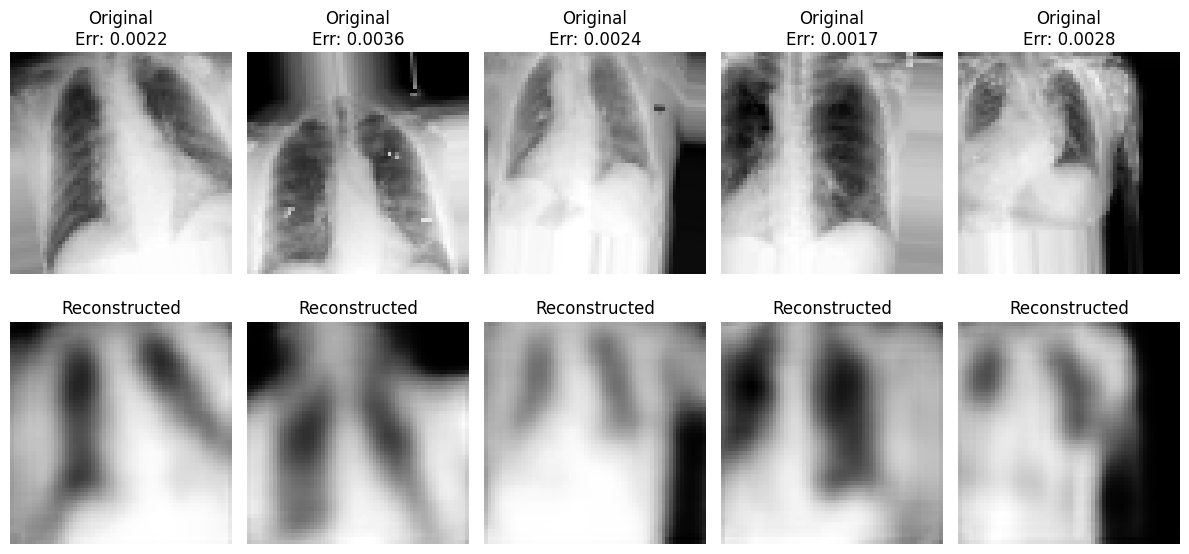

In [22]:
import matplotlib.pyplot as plt

n = 5  # number of images to display
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f'Original\nErr: {reconstruction_errors[i]:.4f}')
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')
plt.tight_layout()
plt.show()
